In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib as plt


## 1. Carga de datos

In [2]:
df = pd.read_csv(r"C:\Users\basti\OneDrive\Escritorio\Datasets\nyc_taxi_sample.csv")

## 2. Limpieza y preprocesamiento de los datos

Antes de entrenar cualquier modelo, es fundamental entender y preparar bien los datos. En esta sección se revisa el estado inicial del dataset y se aplican transformaciones clave.

### 2.1 Revisión inicial del DataFrame
Se utiliza `df.info()` para conocer:
- El número total de filas y columnas.
- El tipo de datos de cada columna.
- La cantidad de valores no nulos por variable.

Esto permite identificar rápidamente columnas con datos faltantes, como:
- `passenger_count`
- `RatecodeID`
- `congestion_surcharge`
- `Airport_fee`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               500000 non-null  int64  
 1   tpep_pickup_datetime   500000 non-null  object 
 2   tpep_dropoff_datetime  500000 non-null  object 
 3   passenger_count        486188 non-null  float64
 4   trip_distance          500000 non-null  float64
 5   RatecodeID             486188 non-null  float64
 6   PULocationID           500000 non-null  int64  
 7   DOLocationID           500000 non-null  int64  
 8   payment_type           500000 non-null  int64  
 9   fare_amount            500000 non-null  float64
 10  extra                  500000 non-null  float64
 11  mta_tax                500000 non-null  float64
 12  tip_amount             500000 non-null  float64
 13  tolls_amount           500000 non-null  float64
 14  improvement_surcharge  500000 non-nu

### 2.2 Ingeniería de características
Se crean nuevas columnas a partir de `tpep_pickup_datetime`:

- `pickup_hour`: Hora en la que inicia el viaje.
- `dayWeek`: Día de la semana (0 = lunes, 6 = domingo).
- `is_weekend`: Indica si el viaje fue sábado o domingo.
- `isnight`: Bandera que indica si el viaje fue de noche (entre las 22:00 y las 6:00).
- `is_airport_trip`: Marca si el viaje incluyó un cargo de aeropuerto.

In [4]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['dayWeek'] = df['tpep_pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayWeekend'].isin([5, 6]).astype(int)
def esNoche(hora):
    return (hora >=22) | (hora <=6)
df['isnight'] = df['pickup_hour'].apply(esNoche).astype(int)
df['is_airport_trip'] = (df['Airport_fee']>0).astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               500000 non-null  int64         
 1   tpep_pickup_datetime   500000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  500000 non-null  object        
 3   passenger_count        486188 non-null  float64       
 4   trip_distance          500000 non-null  float64       
 5   RatecodeID             486188 non-null  float64       
 6   PULocationID           500000 non-null  int64         
 7   DOLocationID           500000 non-null  int64         
 8   payment_type           500000 non-null  int64         
 9   fare_amount            500000 non-null  float64       
 10  extra                  500000 non-null  float64       
 11  mta_tax                500000 non-null  float64       
 12  tip_amount             500000 non-null  floa

In [6]:
cols_to_drop = [
    "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "payment_type",
    "total_amount", "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "congestion_surcharge", "Airport_fee",
     "dayWeekend"
]
df = df.drop(columns=cols_to_drop)

In [7]:
df[['passenger_count','RatecodeID']].isnull().sum()
mode_passenger = df['passenger_count'].mode()[0]
df['passenger_count'] = df['passenger_count'].fillna(mode_passenger)
RatecodeID = df['RatecodeID'].mode()[0]
df['RatecodeID'] = df['RatecodeID'].fillna(mode_passenger)

In [8]:
df = df.astype({
    'passenger_count': 'int32',      
    'trip_distance': 'float32',       
    'RatecodeID': 'int8',             
    'PULocationID': 'int16',       
    'DOLocationID': 'int16',         
    'fare_amount': 'float32',        
    'pickup_hour': 'int8',             
    'is_weekend': 'int8',             
    'isnight': 'int8',                
    'dayWeek': 'int8',                
    'is_airport_trip': 'int8'         
})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   passenger_count  500000 non-null  int32  
 1   trip_distance    500000 non-null  float32
 2   RatecodeID       500000 non-null  int8   
 3   PULocationID     500000 non-null  int16  
 4   DOLocationID     500000 non-null  int16  
 5   fare_amount      500000 non-null  float32
 6   pickup_hour      500000 non-null  int8   
 7   is_weekend       500000 non-null  int8   
 8   isnight          500000 non-null  int8   
 9   dayWeek          500000 non-null  int8   
 10  is_airport_trip  500000 non-null  int8   
dtypes: float32(2), int16(2), int32(1), int8(6)
memory usage: 10.5 MB


## 3. Detección de valores anómalos y filtrado de outliers

### 3.1 Revisión de estadísticos generales

Tras imputar valores nulos y convertir los tipos de datos, se aplica `df.describe()` para revisar los estadísticos generales de las variables numéricas. En esta etapa se detectan valores inusuales:


In [10]:
df.describe()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,pickup_hour,is_weekend,isnight,dayWeek,is_airport_trip
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.352396,4.394863,1.554444,165.587564,164.029636,19.131809,14.281756,0.269062,0.185966,3.006288,0.068710
std,0.879331,345.220886,6.877623,64.058410,69.962527,18.500603,5.793709,0.443473,0.389080,1.922482,0.252961
min,0.000000,0.000000,1.000000,1.000000,1.000000,-768.099976,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.070000,1.000000,132.000000,114.000000,9.300000,11.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.800000,1.000000,162.000000,162.000000,13.500000,15.000000,0.000000,0.000000,3.000000,0.000000
75%,1.000000,3.410000,1.000000,234.000000,234.000000,21.200001,19.000000,1.000000,0.000000,5.000000,0.000000
max,7.000000,225987.375000,99.000000,265.000000,265.000000,1001.900024,23.000000,1.000000,1.000000,6.000000,1.000000


`fare_amount` tiene un valor mínimo de **-768**, lo que no tiene sentido físico, ya que una tarifa no puede ser negativa.  
También se observan valores muy altos en `fare_amount` y `trip_distance`, que probablemente correspondan a outliers.

Estos hallazgos motivan la aplicación de filtros para eliminar registros anómalos y trabajar con datos más consistentes.

### 3.2 Validación de la variable `isnight`

Se realiza un análisis para comprobar si la variable `isnight` (que indica si el viaje ocurrió durante la noche) tiene algún efecto sobre la tarifa.

Los resultados muestran lo siguiente:

- **Viajes de día (`isnight = 0`)**: tarifa promedio ≈ 18.9
- **Viajes de noche (`isnight = 1`)**: tarifa promedio ≈ 19.9

Esto sugiere una leve diferencia, posiblemente relacionada con tarifas nocturnas, tráfico reducido o mayor distancia promedio.


In [11]:
df.groupby('isnight')['fare_amount'].mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   passenger_count  500000 non-null  int32  
 1   trip_distance    500000 non-null  float32
 2   RatecodeID       500000 non-null  int8   
 3   PULocationID     500000 non-null  int16  
 4   DOLocationID     500000 non-null  int16  
 5   fare_amount      500000 non-null  float32
 6   pickup_hour      500000 non-null  int8   
 7   is_weekend       500000 non-null  int8   
 8   isnight          500000 non-null  int8   
 9   dayWeek          500000 non-null  int8   
 10  is_airport_trip  500000 non-null  int8   
dtypes: float32(2), int16(2), int32(1), int8(6)
memory usage: 10.5 MB




### 3.3 Filtros aplicados para remover outliers

Para mejorar la calidad del dataset y evitar que valores extremos influyan negativamente en el modelo, se aplican los siguientes filtros:

- `fare_amount` > 0 y < 150
- `trip_distance` > 0 y < 50
- `passenger_count` > 0
- `RatecodeID` ≤ 6 (el rango documentado va de 1 a 6)

Estas condiciones están basadas en la lógica del dominio y ayudan a asegurar que los datos reflejen situaciones reales de transporte dentro de la ciudad.

---

Con estos filtros, el dataset queda más limpio y robusto para los siguientes pasos del análisis exploratorio y el modelado predictivo.


In [12]:
df= df[(df['fare_amount'] > 0) & (df['fare_amount'] < 150)]
df= df[df['passenger_count'] > 0]
df = df[(df['trip_distance'] < 50) & (df['trip_distance'] > 0)]
df = df[df['RatecodeID'] <=5 ] 

## 4. Análisis exploratorio visual (EDA)


### 4.1 Histogramas y KDE

Distribución de variables numéricas:
- `passenger_count`: mayoría con 1 pasajero.
- `trip_distance`: la mayoría entre 0–5 millas.
- `pickup_hour`: mayor frecuencia entre 15–20 hrs.
- `fare_amount`: sesgada, con mayoría entre 5–25 USD y outliers sobre 60 USD.

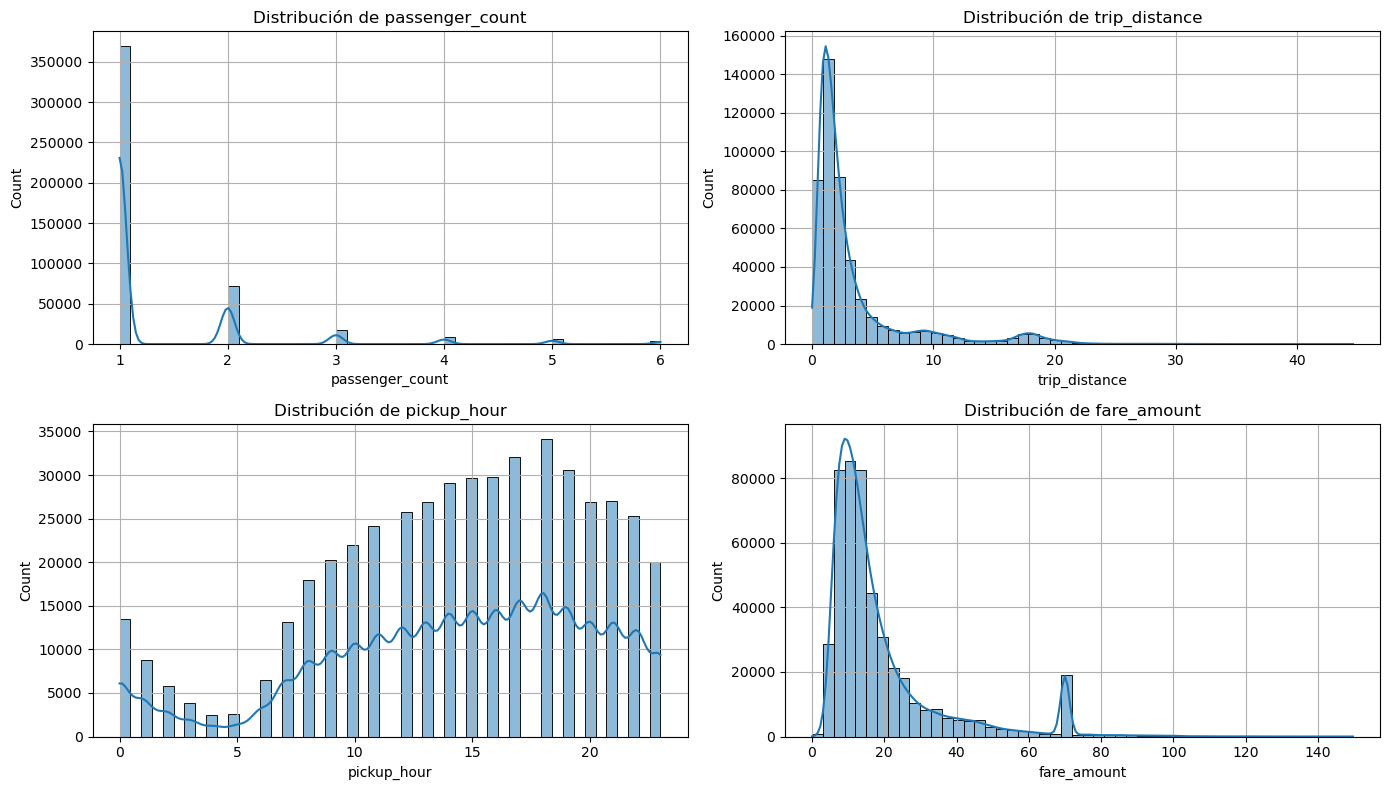

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


num_vars = ['passenger_count', 'trip_distance', 'pickup_hour', 'fare_amount']

fig, axs = plt.subplots(2, 2, figsize=(14, 8))  # 2x2 grid
axs = axs.flatten()

for i, col in enumerate(num_vars):
    sns.histplot(df[col], kde=True, bins=50, ax=axs[i])
    axs[i].set_title(f'Distribución de {col}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()




### 4.2 Countplots

- `RatecodeID`: dominada por categoría 1 (tarifa estándar).
- `PULocationID` y `DOLocationID`: top 20 más frecuentes fueron graficados, y el resto agrupado como “otros”.
- Variables binarias (`is_weekend`, `isnight`, etc.) tienen distribución razonable.


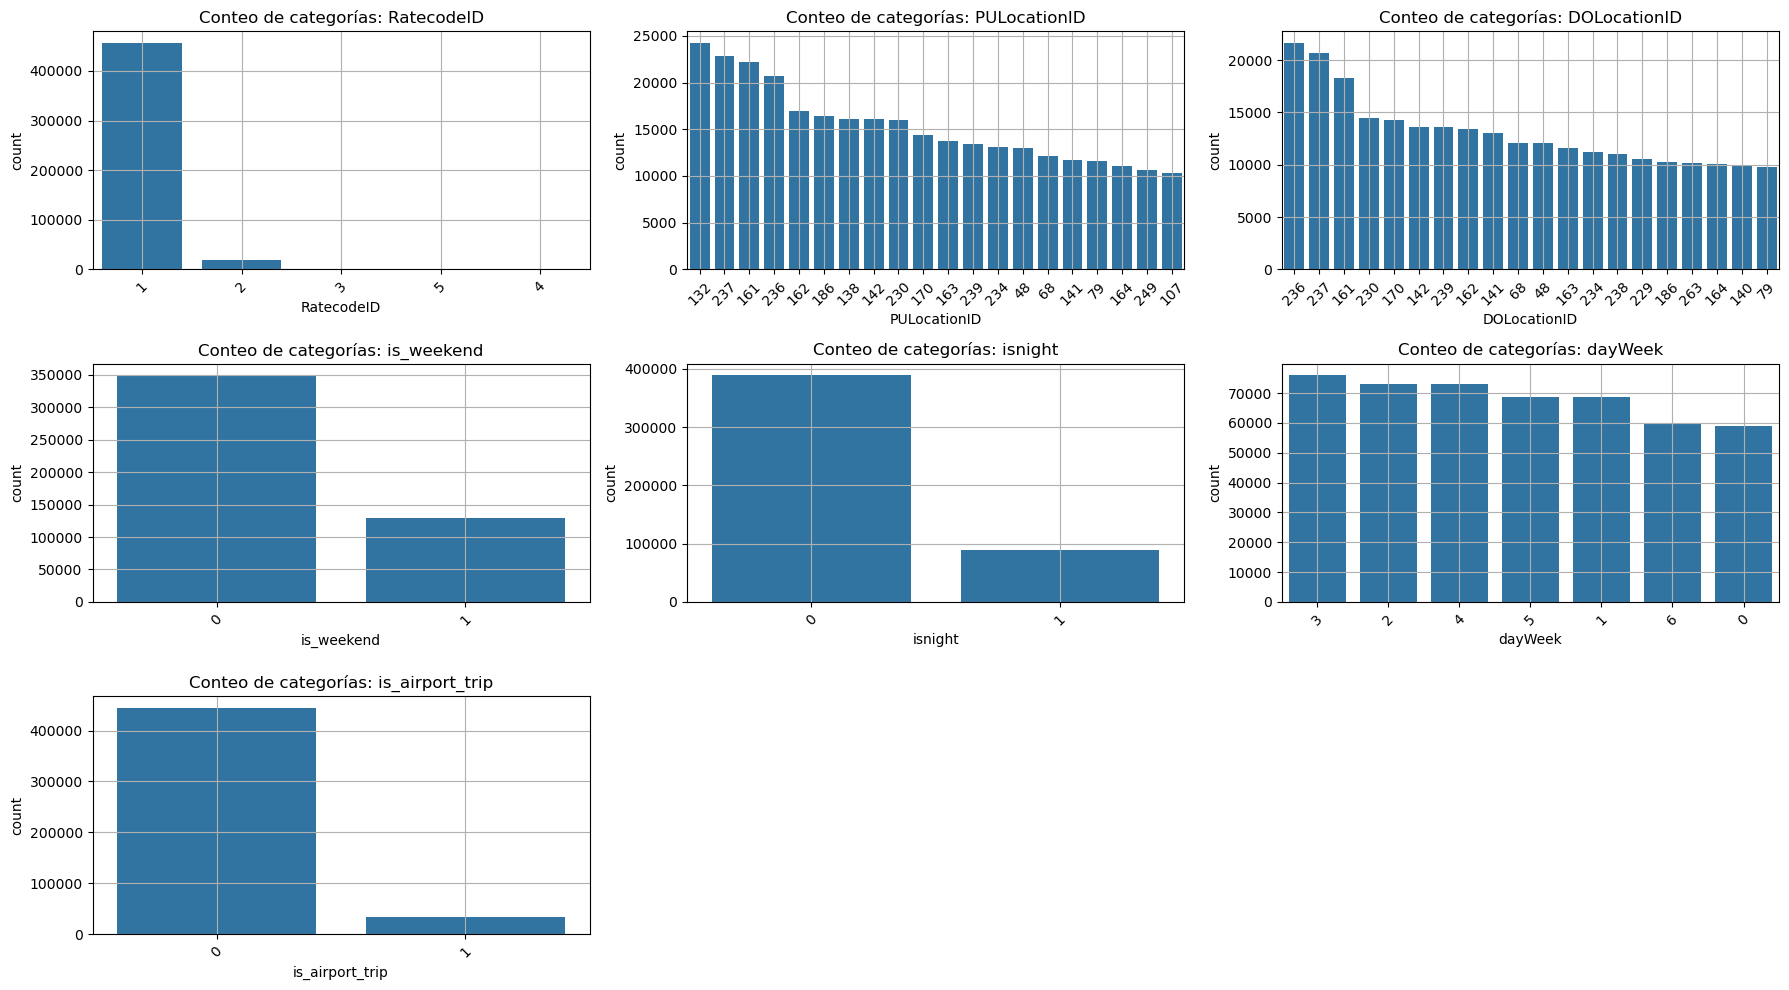

In [14]:
cat_vars = ['RatecodeID', 'PULocationID', 'DOLocationID', 'is_weekend', 'isnight', 'dayWeek', 'is_airport_trip']

fig, axs = plt.subplots(3, 3, figsize=(18, 10))
axs = axs.flatten()

for i, col in enumerate(cat_vars):
    sns.countplot(x=col, data=df, order=df[col].value_counts().index[:20], ax=axs[i])
    axs[i].set_title(f'Conteo de categorías: {col}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

# Ocultar los ejes vacíos si hay más subplots que columnas
for j in range(len(cat_vars), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


### 4.3 Boxplots

- `fare_amount` es más alto en `RatecodeID` ≠ 1.
- Los viajes desde `PULocationID` 132 son más caros.
- `is_airport_trip = 1` claramente eleva la tarifa.

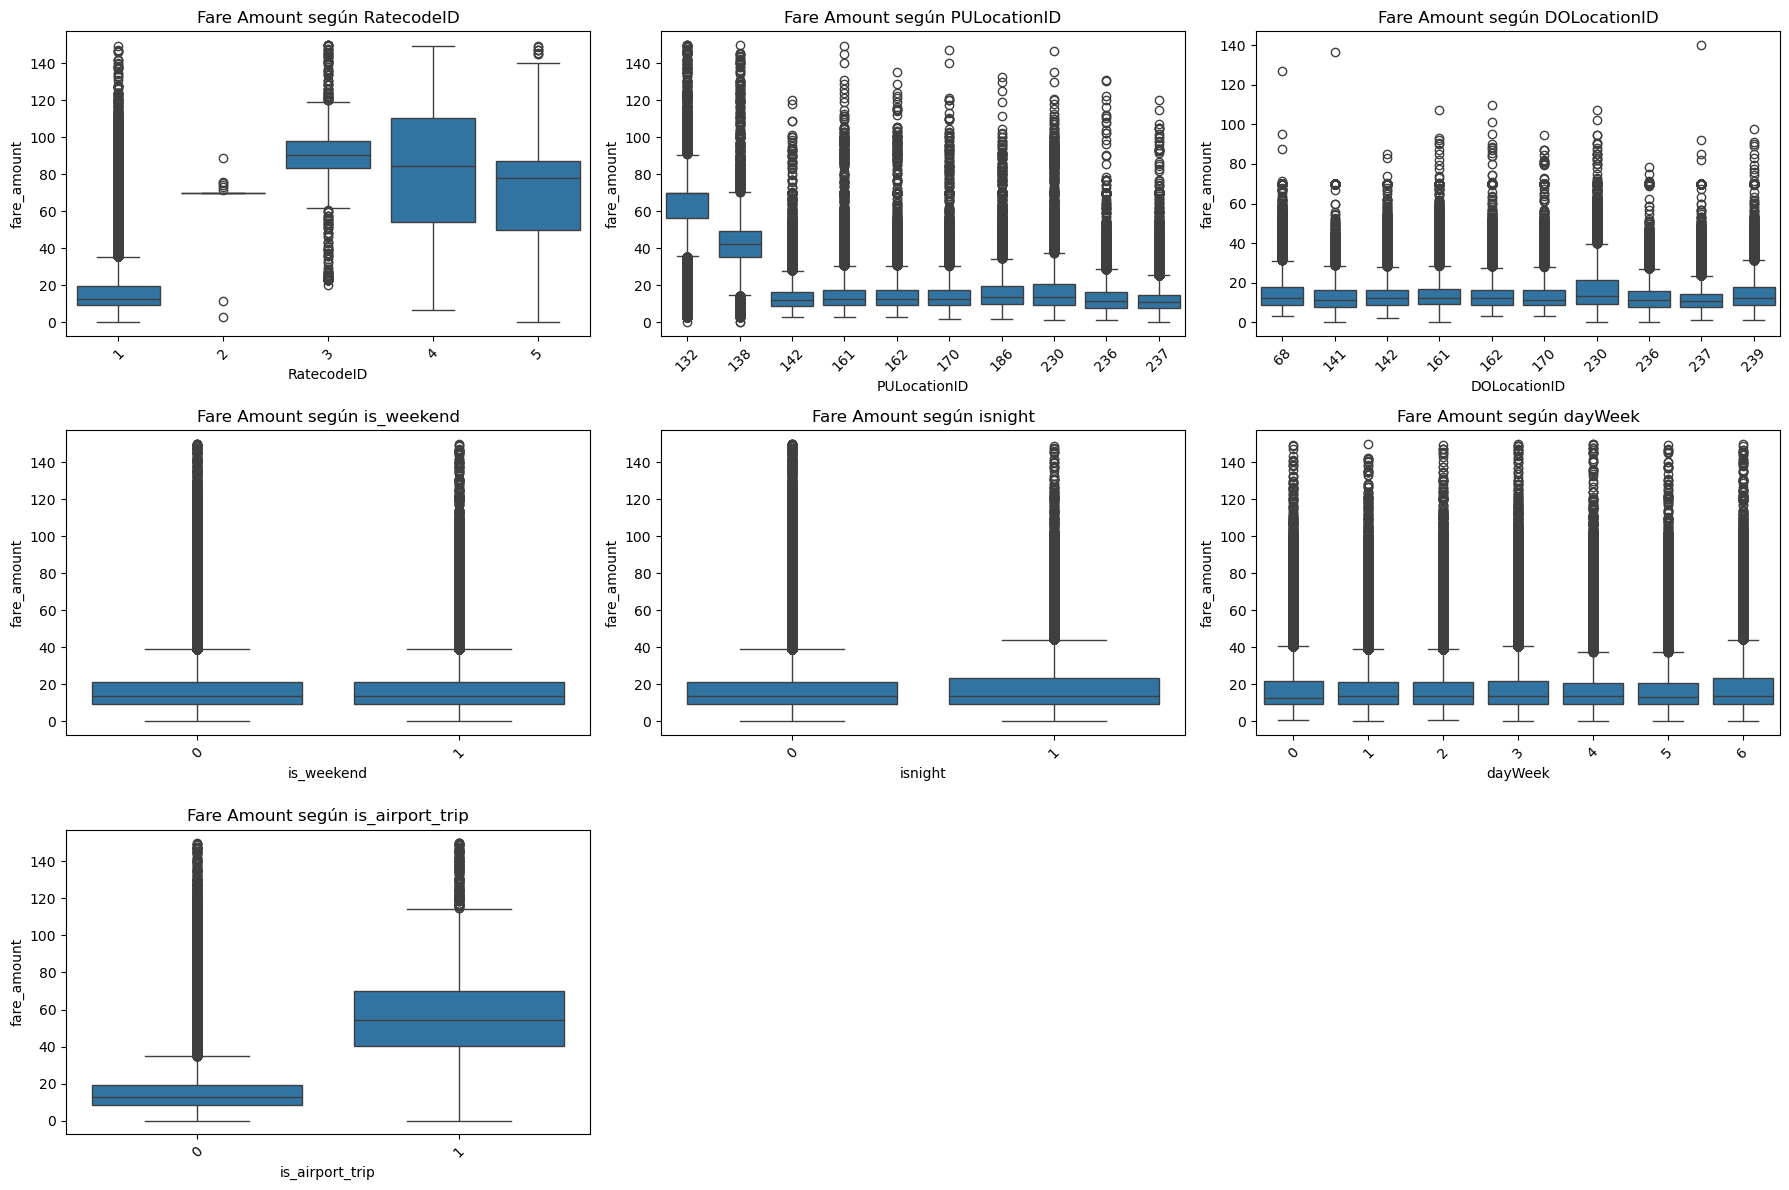

In [15]:

fig, axs = plt.subplots(3, 3, figsize=(18, 12))
axs = axs.flatten()

for i, col in enumerate(cat_vars):
    if df[col].nunique() > 15:
        top_cats = df[col].value_counts().nlargest(10).index
        data_plot = df[df[col].isin(top_cats)]
    else:
        data_plot = df

    sns.boxplot(x=col, y='fare_amount', data=data_plot, ax=axs[i])
    axs[i].set_title(f'Fare Amount según {col}')
    axs[i].tick_params(axis='x', rotation=45)

for j in range(len(cat_vars), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

### 4.4 Scatterplots

- `trip_distance` muestra relación lineal con `fare_amount`.
- `passenger_count` y `pickup_hour` no presentan correlaciones fuertes, pero revelan bandas verticales y horizontales esperables.


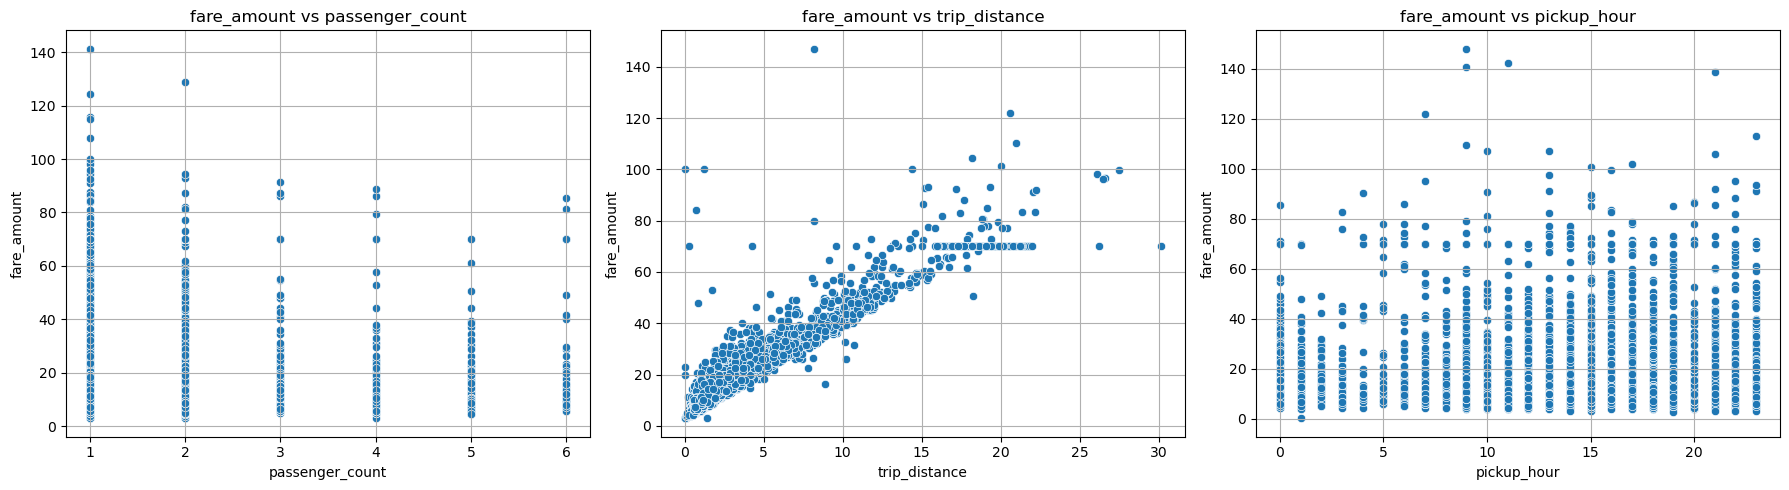

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

num_plot_vars = [col for col in num_vars if col != 'fare_amount']

for i, col in enumerate(num_plot_vars):
    sns.scatterplot(x=col, y='fare_amount', data=df.sample(5000), ax=axs[i])
    axs[i].set_title(f'fare_amount vs {col}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [17]:
df.describe()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,pickup_hour,is_weekend,isnight,dayWeek,is_airport_trip
count,478217.000000,478217.000000,478217.000000,478217.000000,478217.000000,478217.000000,478217.000000,478217.000000,478217.000000,478217.000000,478217.000000
mean,1.378654,3.476166,1.056221,165.867629,164.141998,19.212811,14.317465,0.269328,0.185895,3.007384,0.069583
std,0.872847,4.387291,0.300581,63.859807,69.833093,16.703291,5.792475,0.443611,0.389022,1.921834,0.254444
min,1.000000,0.010000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.100000,1.000000,132.000000,114.000000,9.300000,11.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.830000,1.000000,162.000000,162.000000,13.500000,15.000000,0.000000,0.000000,3.000000,0.000000
75%,1.000000,3.450000,1.000000,234.000000,234.000000,21.200001,19.000000,1.000000,0.000000,5.000000,0.000000
max,6.000000,44.590000,5.000000,265.000000,265.000000,149.699997,23.000000,1.000000,1.000000,6.000000,1.000000


## 4. Codificación y transformación de variables categóricas

Para reducir la dimensionalidad y el ruido de categorías poco frecuentes, se agruparon las 20 ubicaciones más comunes (`PULocationID`, `DOLocationID`) y se agruparon las restantes bajo el nombre `"Otros"`. Luego, se aplicó One-Hot Encoding (`get_dummies`) sobre `RatecodeID`, `PULocationID`, y `DOLocationID`, dejando fuera la primera categoría para evitar multicolinealidad.


In [18]:


# Función para agrupar categorías menos frecuentes en "Otros"
def agrupar_top(df, col, top_n=20):
    top_cats = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_cats else 'Otros')
    return df


df = agrupar_top(df, 'PULocationID', top_n=20)
df = agrupar_top(df, 'DOLocationID', top_n=20)


nominales = ['PULocationID', 'DOLocationID', 'RatecodeID']


df_encoded = pd.get_dummies(df, columns=nominales, drop_first=True)



## 5. Transformación cíclica de variables temporales

Las variables temporales como la hora (`pickup_hour`) y el día de la semana (`dayWeek`) son cíclicas. Para capturar esta naturaleza, se aplicaron funciones seno y coseno, generando nuevas variables:

- `day_sin`, `day_cos` para `dayWeek`
- `hour_sin`, `hour_cos` para `pickup_hour`

Esto permite representar correctamente la cercanía entre valores como la hora 23 y la hora 0.


In [19]:
df_encoded['day_sin'] = np.sin(2 * np.pi * df['dayWeek'] / 7)
df_encoded['day_cos'] = np.cos(2 * np.pi * df['dayWeek'] / 7)


df_encoded['hour_sin'] = np.sin(2 * np.pi * df['pickup_hour'] / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df['pickup_hour'] / 24)

df_encoded.drop(columns=['dayWeek'], inplace=True)
df_encoded.drop(columns=['pickup_hour'], inplace=True)


## 6. Escalamiento y partición de datos

Se estandarizaron las variables numéricas (`passenger_count` y `trip_distance`) con `StandardScaler`, lo que mejora el rendimiento de modelos como la regresión lineal.  
Luego se dividió el dataset en conjuntos de entrenamiento (80%) y prueba (20%) para evaluar la generalización del modelo.


In [20]:
num_cols = ['passenger_count', 'trip_distance'] 
X = df_encoded.drop(columns=['fare_amount'])
y = df_encoded['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


## 7. Regresión Lineal

Se entrenó un modelo de regresión lineal como punto de partida.

**Resultados:**

- **MSE**: 17.909
- **MAE**: 2.456
- **R²**: 0.936

Se obtuvo un rendimiento decente, aunque el gráfico de residuos vs. predicciones mostró cierta estructura, lo que indica que la regresión lineal no captura completamente las relaciones no lineales.


In [21]:

model = LinearRegression()


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.3f}')
print(f'MAE: {mae:.3f}')
print(f'R2: {r2:.3f}')


MSE: 17.909
MAE: 2.450
R2: 0.936


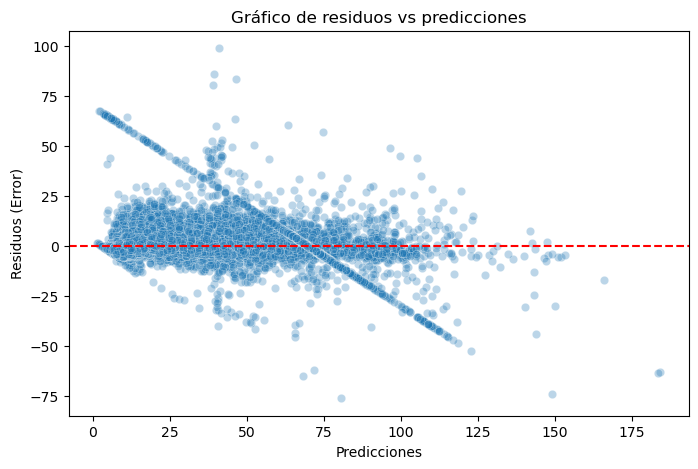

In [22]:

residuos = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos (Error)')
plt.title('Gráfico de residuos vs predicciones')
plt.show()


## 8. Random Forest Regressor

Se utilizó un modelo no lineal `RandomForestRegressor` para mejorar el desempeño.

**Resultados:**

- **MSE**: 9.927
- **MAE**: 1.887
- **R²**: 0.964

El modelo mejoró significativamente en todas las métricas. El gráfico de residuos mostró una dispersión más homogénea y menor sesgo.


In [23]:

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest MSE: {mse_rf:.3f}')
print(f'Random Forest MAE: {mae_rf:.3f}')
print(f'Random Forest R2: {r2_rf:.3f}')


Random Forest MSE: 9.927
Random Forest MAE: 1.887
Random Forest R2: 0.964


## 9. Importancia de variables

El gráfico de importancia de características del modelo Random Forest muestra que:

- `trip_distance` es, por lejos, la variable más influyente.
- Le siguen algunas dummies de `RatecodeID`, componentes horarios y `passenger_count`.

Esto puede orientar la selección de variables en modelos futuros.


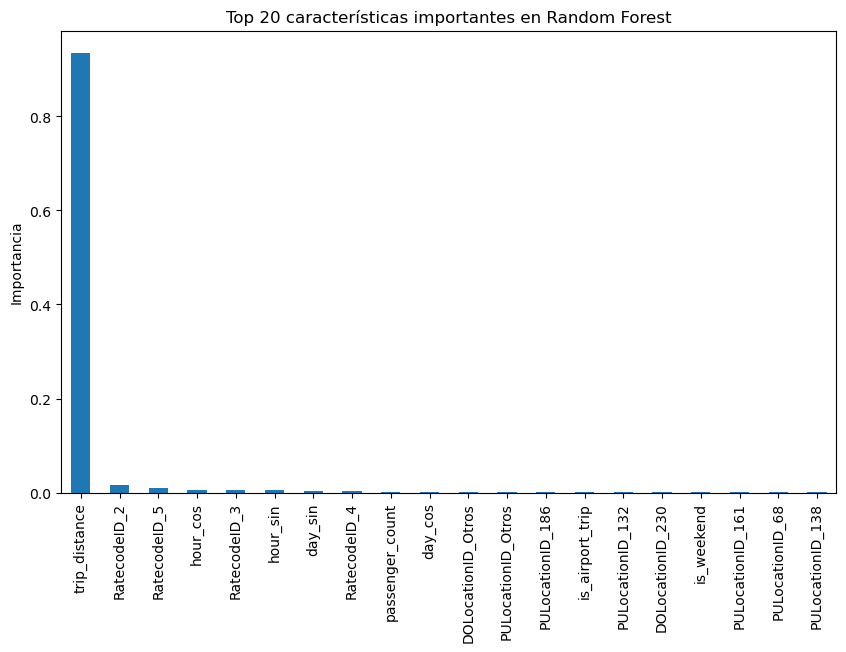

In [24]:

importances = rf.feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind='bar')
plt.title('Top 20 características importantes en Random Forest')
plt.ylabel('Importancia')
plt.show()


## 10. Análisis de error absoluto vs. distancia del viaje

Se analizó cómo varía el error en función de la distancia:

- A menor distancia, los errores tienden a concentrarse en valores bajos.
- A mayor distancia, hay más dispersión y mayor posibilidad de errores altos.
- Se visualizó esta relación con scatterplots y boxplots por rangos de distancia.

Esto es útil para entender en qué segmentos el modelo es más confiable.

In [25]:
y_pred = y_pred_rf
errors = np.abs(y_test - y_pred)

# Agregamos errores y algunas variables clave a un DataFrame
error_df = X_test.copy()
error_df['fare_amount_real'] = y_test
error_df['fare_amount_pred'] = y_pred
error_df['error'] = errors


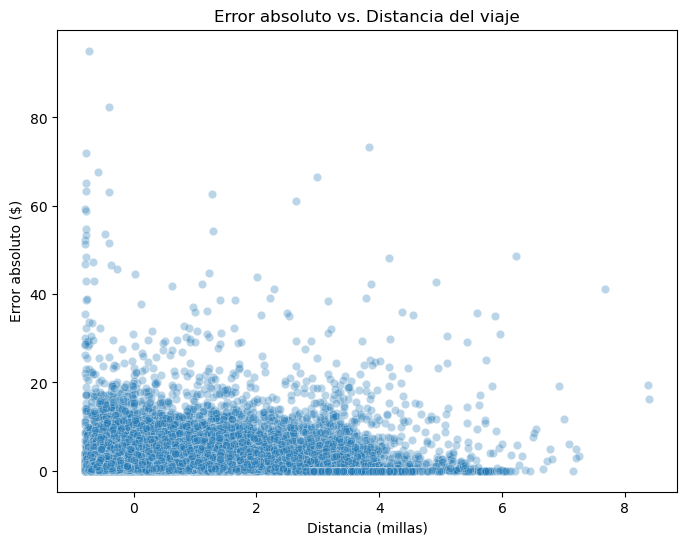

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=error_df['trip_distance'], y=error_df['error'], alpha=0.3)
plt.title("Error absoluto vs. Distancia del viaje")
plt.xlabel("Distancia (millas)")
plt.ylabel("Error absoluto ($)")
plt.show()


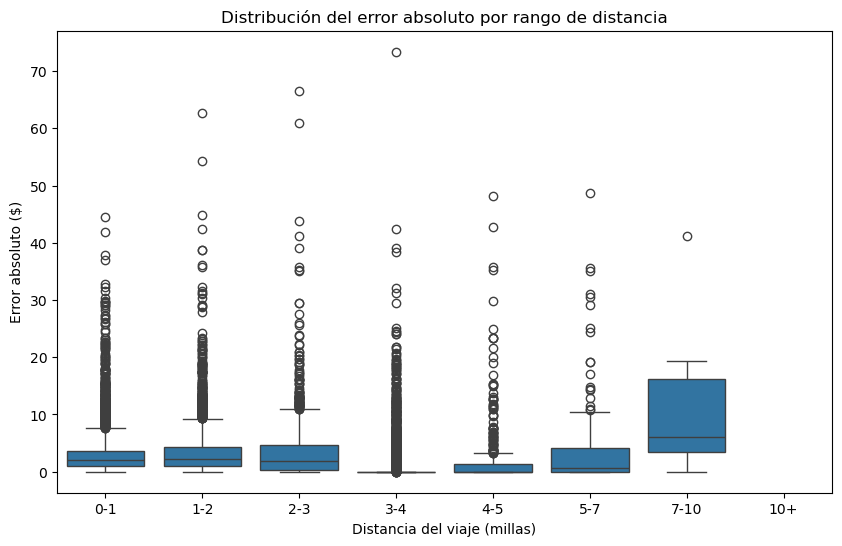

In [27]:
# 1. Calculamos el error absoluto
error_absoluto = np.abs(y_test - y_pred)

# 2. Creamos una copia del set de prueba para graficar
df_error = X_test.copy()
df_error['error_absoluto'] = error_absoluto

# 3. Creamos rangos de distancia (bins)
bins = [0, 1, 2, 3, 4, 5, 7, 10, np.inf]
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-7', '7-10', '10+']
df_error['distancia_bin'] = pd.cut(df_error['trip_distance'], bins=bins, labels=labels)

# 4. Hacemos el boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x='distancia_bin', y='error_absoluto', data=df_error)
plt.title('Distribución del error absoluto por rango de distancia')
plt.xlabel('Distancia del viaje (millas)')
plt.ylabel('Error absoluto ($)')
plt.show()

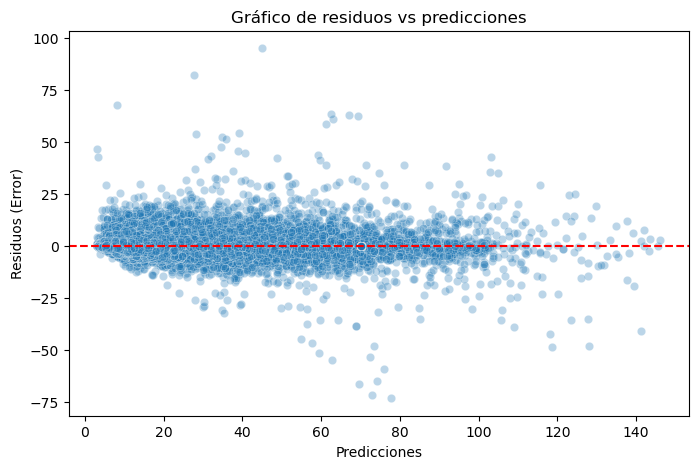

In [28]:


residuos = y_test - y_pred_rf

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred_rf, y=residuos, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos (Error)')
plt.title('Gráfico de residuos vs predicciones')
plt.show()





Se aplicó validación cruzada de 5 pliegues al modelo Random Forest para validar su robustez.

**Resultados:**

- **R² promedio CV**: 0.964
- **Desviación estándar CV**: 0.001

Esto sugiere que el modelo generaliza bien y tiene buen rendimiento con distintos subconjuntos de datos.


In [29]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5, scoring='r2', n_jobs=-1)
 
print(f'R2 promedio CV: {np.mean(scores):.3f}')
print(f'Desviación estándar CV: {np.std(scores):.3f}')


R2 promedio CV: 0.964
Desviación estándar CV: 0.001


## 🧾 Conclusiones Generales del Proyecto

Este proyecto tuvo como objetivo predecir el valor de la tarifa (`fare_amount`) de un viaje en taxi en la ciudad de Nueva York, utilizando datos de pickups registrados en 2023. A través del pipeline de análisis se aplicaron técnicas modernas de procesamiento, exploración, transformación de datos y entrenamiento de modelos de machine learning.

### ✅ Principales aprendizajes y hallazgos

- Se realizó una **limpieza exhaustiva de datos**, eliminando registros con valores imposibles (como tarifas negativas o distancias exageradas).
- Se construyeron nuevas variables relevantes a partir de la información temporal y de contexto, como si era fin de semana, horario nocturno o viaje desde/hacia aeropuerto.
- Se aplicaron **técnicas de ingeniería de variables**, como codificación categórica, agrupación de categorías poco frecuentes y transformación cíclica de variables temporales.
- Se compararon dos modelos: una **Regresión Lineal** y un **Random Forest**, observando que el segundo tuvo mejor capacidad para capturar relaciones no lineales y reducir el error.
- El **Random Forest obtuvo un R² de 0.96** y un MAE cercano a 1.9, lo que indica un modelo muy sólido para este tipo de predicción.
- Se analizaron los errores de predicción en función de la distancia, observando mayor error en viajes largos, lo cual es esperable por su mayor variabilidad.
- Se validó el modelo mediante **validación cruzada**, confirmando su estabilidad y bajo riesgo de sobreajuste.

### 🚀 Próximos pasos posibles

- Probar modelos más sofisticados como **Gradient Boosting (XGBoost, LightGBM)**.
- Realizar **selección de características** o aplicar técnicas de reducción de dimensionalidad (ej. PCA).
- Experimentar con **segmentación de modelos**, por ejemplo, uno para viajes cortos y otro para viajes largos.


